# Regression

In [2]:
# Data Manipulation
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Data-Viz
import matplotlib.pyplot as plt
import seaborn as sns

# OLS
import statsmodels.api as sm
from scipy import stats

# Boosting Forest
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import (
    r2_score,
    mean_squared_error   
)
import dalex as dx
import shap

## Reading data

In [3]:
train = pd.read_csv('../data/regression_data/regression_train.csv')
train

,target,X1,X2,X3,X4,X5,X6,X7
0,NaN,-0.546168,NaN,47.063305,1.611370,-65.882137,0,-16.672865
1,47.735389,3.074317,-2.836000,49.396649,0.261998,-66.570716,0,-6.664599
2,NaN,-1.485531,-13.102537,42.367991,3.991558,-67.108014,8,-30.790962
3,908.202209,6.907396,-0.308967,57.228787,0.256771,-66.181266,5,-0.726072
4,1640.461863,1.916788,3.460290,51.703375,2.463790,-65.143663,5,8.131680
...,...,...,...,...,...,...,...,...
1037,4296.426459,5.375810,6.937947,55.810467,1.698025,-65.819509,8,16.304176
1038,54.530919,0.619207,-1.925819,48.168606,1.357223,-65.385243,8,-4.525675
1039,1636.535078,4.548172,2.886253,47.775525,1.278439,-56.312543,8,6.782694
1040,NaN,1.806045,-3.015213,48.352707,4.627906,-57.722688,5,-7.085751


In [4]:
train.isna().mean()

target    0.313820
X1        0.000000
X2        0.010557
X3        0.000000
X4        0.000000
X5        0.000000
X6        0.000000
X7        0.000000
dtype: float64

In [5]:
test = pd.read_csv('../data/regression_data/regression_test.csv')
test

,target,X1,X2,X3,X4,X5,X6,X7
0,3.436244,0.210854,-2.451307,51.239996,4.641751,-67.874319,5,-5.760571
1,1525.839412,2.157483,4.337776,43.828794,8.070219,-68.405526,8,10.193773
2,455.600191,5.166359,-0.452615,43.931305,1.349625,-66.240021,0,-1.063645
3,0.619759,3.276641,-3.607201,50.631046,2.473542,-69.971690,8,-8.476921
4,10.996472,-1.867485,-2.408863,58.660224,2.826219,-53.647149,5,-5.660827
...,...,...,...,...,...,...,...,...
256,555.785223,5.099614,-0.648889,54.770941,1.975509,-61.664039,8,-1.524890
257,624.578115,0.220241,1.410877,42.895015,0.639779,-66.077209,0,3.315561
258,NaN,1.066213,-5.569022,51.318035,1.994699,-64.081511,0,-13.087202
259,NaN,-2.260013,-10.854081,38.671378,1.065288,-66.732946,0,-25.507091


In [6]:
test.isna().mean()

target    0.310345
X1        0.000000
X2        0.000000
X3        0.000000
X4        0.000000
X5        0.000000
X6        0.000000
X7        0.000000
dtype: float64

Como temos muito NA's na própria variável "target", iremos apenas remover as linhas que contém esses NA's. O nosso objetivo é criar um regressor da variável target, sem ela não adianta as informações providenciadas pelas outras colunas.

In [7]:
train.dropna(inplace=True)
test.dropna(inplace=True)

## EDA

<AxesSubplot:>

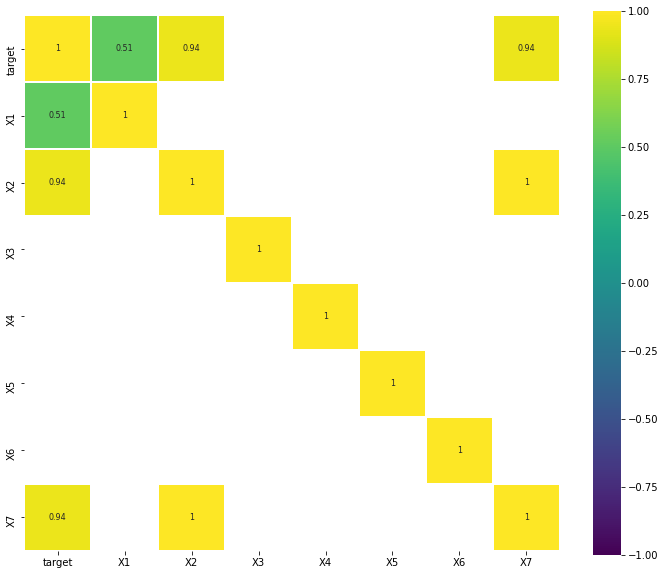

In [8]:
corr = train.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr[abs(corr) > 0.4],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

Podemos ver que 'target' tem uma correlação linear muito forte com X1, X2 e X7. O que nos aponta que utilizar modelos lineares seria adequado.

Além disso, notamos a correlação muito elevada entre X7 e X2.

array([[<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'X1'}>,
        <AxesSubplot:title={'center':'X2'}>],
       [<AxesSubplot:title={'center':'X3'}>,
        <AxesSubplot:title={'center':'X4'}>,
        <AxesSubplot:title={'center':'X5'}>],
       [<AxesSubplot:title={'center':'X6'}>,
        <AxesSubplot:title={'center':'X7'}>, <AxesSubplot:>]],
      dtype=object)

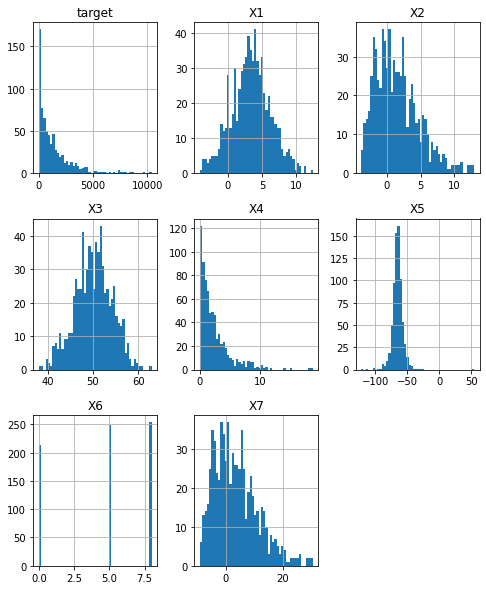

In [9]:
train.hist(figsize=(8, 10), bins=50)

Vemos a variável 'target' como não-negativa com caráter de distribuição Exponencial ou Gamma. Outro ponto a se notar é que haveria apenas uma distribuição de valores discretos, a X6.

## Modelling

## Regressão Linear Múltipla

Inicialmente, iremos modelar usando Regressão Linear Múltipla, onde se assume que a variável 'target' tem distribuição normal, além de assumir variância única para todas as observações. Outra questão é que o valor esperado da regressão linear pode assumir qualquer valor na reta Real, porém podemos observar que nossa variável 'target' é uma variável não-negativa. Poderíamos modelar através de GLM, porém, há uma outra opção:

Iremos realizar uma transformação Box-Cox, na qual consiste em uma tentativa de normalizar os dados para acomodar melhor a Regresão Linear.

In [10]:
fitted_data, lambda_value = stats.boxcox(train['target'])
train['target'] = fitted_data
test['target'] = stats.boxcox(test['target'], lmbda=lambda_value)

(array([ 1.,  1.,  4.,  3.,  7.,  4.,  7.,  9.,  6., 10.,  8., 12., 14.,
        14., 14., 22., 26., 25., 22., 17., 21., 30., 23., 24., 27., 19.,
        34., 31., 23., 37., 23., 25., 27., 17., 19., 17., 16., 16., 12.,
        13.,  6.,  6.,  4.,  3.,  2.,  7.,  3.,  2.,  0.,  2.]),
 array([-2.0048907 , -1.24699702, -0.48910335,  0.26879032,  1.026684  ,
         1.78457767,  2.54247134,  3.30036502,  4.05825869,  4.81615236,
         5.57404604,  6.33193971,  7.08983338,  7.84772706,  8.60562073,
         9.3635144 , 10.12140808, 10.87930175, 11.63719542, 12.3950891 ,
        13.15298277, 13.91087644, 14.66877012, 15.42666379, 16.18455746,
        16.94245114, 17.70034481, 18.45823848, 19.21613216, 19.97402583,
        20.7319195 , 21.48981318, 22.24770685, 23.00560052, 23.7634942 ,
        24.52138787, 25.27928154, 26.03717522, 26.79506889, 27.55296256,
        28.31085624, 29.06874991, 29.82664358, 30.58453726, 31.34243093,
        32.1003246 , 32.85821828, 33.61611195, 34.37400562,

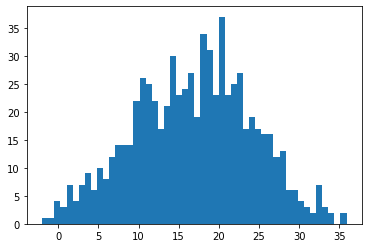

In [11]:
plt.hist(train['target'], bins=50)

Iremos agora modelar os dados. Como notamos anteriormente, X2 e X7 são extremamente correlacionados o que pode nos levar a problemas númericos em estimar o inverso da matrix (X^t X)^{-1}, que é parte do processo de estimação dos coeficientes da Regressão Linear. Sendo assim, iremos conduzir uma análise retirando a variável X7.

In [12]:
train['const'] = 1
reg = sm.OLS(endog=train['target'], exog=train.drop(columns=['target', 'X7']),
             missing='drop', hasconst=True)
results = reg.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     1799.
Date:                Mon, 10 May 2021   Prob (F-statistic):               0.00
Time:                        09:47:05   Log-Likelihood:                -1442.7
No. Observations:                 715   AIC:                             2899.
Df Residuals:                     708   BIC:                             2931.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X1             0.5424      0.026     20.574      0.0

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


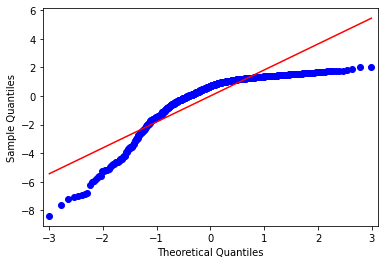

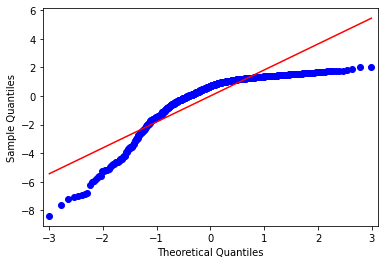

In [13]:
sm.qqplot(results.resid, line='s')

Como podemos ver, não podemos confiar na nossa hipótese de distribuição gaussiana para a variável 'target', pois temos que se isso foste verdadeiro, os resíduos gerados pelo modelo também teriam distribuição gaussiana, o que não é verdade. Embora, as estimativas dos coeficientes sejam não-viezadas (no caso em que os resíduos tem média 0), não podemos confiar nas estimativas para a variância de cada coeficiente, e nem podemos confiar no teste t ou teste marginal para identificar se aquele coeficiente é sequer importante. 

## Regressão Bootstrap

Sendo assim, iremos realizar **Regressão Bootstrap**. Ou seja, iremos amostrar N amostras B vezes e para cada b-ésima vez iremos estimar os parâmetros da regressão. Essas amostras são _com reposição_. Sendo assim, teremos uma distribuição empírica que nos trará confiança sobre as conclusões inferenciais que traremos sobre ela. O valor que escolheremos de N será do próprio tamanho da amostra original.

O nosso modelo consiste em descrever y = X\beta + e. Onde teremos somente duas hipóteses:

1. E(e) = 0.
2. As variáveis são independentemente distribuídas.

Iremos utilizar a média dos resíduos para checar a hipótese 1, e utilizar a estatística de Durbin-Watson para checar a hipótese 2.

Como sabemos pela teoria de bootstrap, temos que a média da distribuição empírica é um estimador não viezado e de variância mínima para o valor esperado da distribuição empírica. Ou seja, um bom estimador para os nossos coeficientes \beta. Usaremos ele, portanto.

In [14]:
class OLS_Bootstrap:
    def _get_regression_coef(self, train):
        reg = sm.OLS(endog=train['target'], exog=train.drop(columns=['target']),
                     missing='drop')
        results = reg.fit()

        return results.params

    def _bootstrap_regression_coef(self, data, B):
        boot_df = pd.DataFrame()
        for B in np.arange(B):
            data_b = data.sample(frac=1, replace=True)
            reg_coef_b = self._get_regression_coef(data_b).T
            boot_df = pd.concat([boot_df, reg_coef_b], axis=1)

        boot_df.columns = ['B' + str(i) for i in np.arange(B+1)]

        return boot_df.T
    
    def fit(self, data, B):
        self.boot_df = self._bootstrap_regression_coef(data, B)
        self.params = self.boot_df.mean()
        self._train_data = data
        self.resid = self.predict() - data['target']
        self.durbin_watson = sm.stats.stattools.durbin_watson(self.resid)
    
    def confidence_intervals(self, p=0.05):
        return self.boot_df.quantile(q=[p/2, 1-(p/2)], axis=0)
    
    def predict(self, new_data=None):
        if new_data is None:
            new_data = self._train_data
            
        X = new_data.loc[:, self.params.index.tolist()]
        beta = self.params
        y_pred = np.matmul(X.values, beta.values)
            
        return y_pred
    
    def goodness_of_fit(self, new_data=None):        
        if new_data is None:
            y = self._train_data['target']
            y_pred = self.predict()
        else:
            y = new_data['target']
            y_pred = self.predict(new_data)
        
        return {
            'R2': r2_score(y, y_pred),
            'MSE': mean_squared_error(y, y_pred),
            'cor': np.corrcoef(y, y_pred)[0,1]
        }

In [15]:
ols_boot = OLS_Bootstrap()
ols_boot.fit(train.drop(columns='X7'), B=1000)
ols_boot.boot_df

,X1,X2,X3,X4,X5,X6,const
B0,0.557681,1.906295,0.141429,-0.197601,-0.019577,0.014263,4.138674
B1,0.562892,1.969553,0.167622,-0.228658,-0.011524,-0.018792,3.366208
B2,0.561970,1.980925,0.164207,-0.256785,-0.007761,0.025159,3.560686
B3,0.509132,2.008775,0.174800,-0.190809,-0.009945,0.010990,2.962241
B4,0.540008,1.978838,0.164677,-0.197914,-0.023249,0.002985,2.688148
...,...,...,...,...,...,...,...
B995,0.567291,1.916476,0.165355,-0.228395,-0.011183,-0.004176,3.435308
B996,0.550773,2.018552,0.157529,-0.231317,-0.005005,0.035149,4.036018
B997,0.561237,1.962295,0.148664,-0.167777,-0.024831,-0.003988,3.176756
B998,0.566064,1.988423,0.166361,-0.217212,-0.012279,0.029058,3.044495


array([[<AxesSubplot:title={'center':'X1'}>,
        <AxesSubplot:title={'center':'X2'}>,
        <AxesSubplot:title={'center':'X3'}>],
       [<AxesSubplot:title={'center':'X4'}>,
        <AxesSubplot:title={'center':'X5'}>,
        <AxesSubplot:title={'center':'X6'}>],
       [<AxesSubplot:title={'center':'const'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

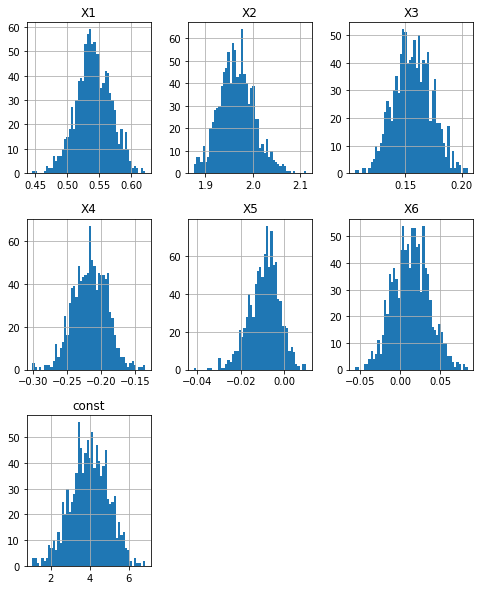

In [16]:
ols_boot.boot_df.hist(figsize=(8, 10), bins=50)

Uma vez tendo encontrado a distribuição empírica dos coeficientes, iremos agora buscar um intervalo de confiança e também realizar um teste de hipótese se os coeficientes são zero ao nível de significância de 5%.

### Teste de Hipótese e Intervalo de Confiança

In [17]:
ols_boot.confidence_intervals()

,X1,X2,X3,X4,X5,X6,const
0.025,0.486086,1.894750,0.124865,-0.264744,-0.023823,-0.028730,2.055767
0.975,0.593027,2.044203,0.188834,-0.169835,0.003624,0.057646,5.760096


Vemos que os coeficientes X6 e a constante são estatisticamente 0 ao nível de significância de 5%. Portanto, iremos rodar novamente a nossa regressão bootstrap sem essas variávéis. Além disso, iremos realizar o teste de hipótese novamente.

In [18]:
ols_boot.fit(train.drop(columns=['X6', 'X5', 'X7']), B = 1000)
ols_boot.boot_df

,X1,X2,X3,X4,const
B0,0.524241,1.954700,0.163624,-0.208636,4.501423
B1,0.547174,1.946292,0.150230,-0.238283,4.980900
B2,0.527367,1.946866,0.159540,-0.168652,4.515623
B3,0.519746,1.958148,0.177612,-0.264017,3.799171
B4,0.525056,1.982213,0.154283,-0.225354,4.840391
...,...,...,...,...,...
B995,0.555331,1.979729,0.165531,-0.251874,4.150205
B996,0.556560,1.897201,0.184671,-0.184223,3.240470
B997,0.545690,1.959012,0.155716,-0.226788,4.591396
B998,0.525935,1.952032,0.166797,-0.176704,4.149847


array([[<AxesSubplot:title={'center':'X1'}>,
        <AxesSubplot:title={'center':'X2'}>],
       [<AxesSubplot:title={'center':'X3'}>,
        <AxesSubplot:title={'center':'X4'}>],
       [<AxesSubplot:title={'center':'const'}>, <AxesSubplot:>]],
      dtype=object)

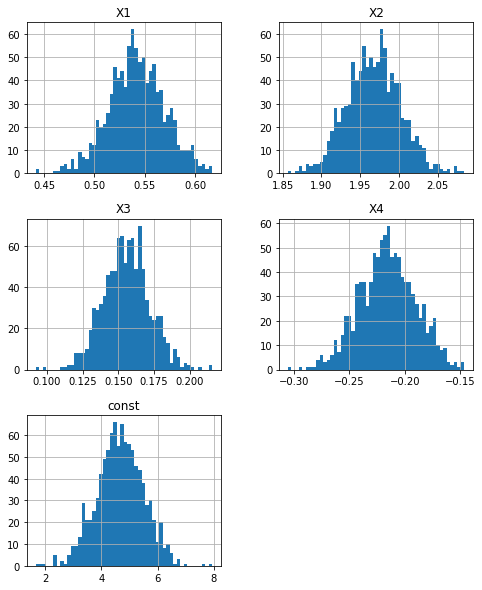

In [19]:
ols_boot.boot_df.hist(figsize=(8, 10), bins=50)

In [20]:
ols_boot.confidence_intervals()

,X1,X2,X3,X4,const
0.025,0.484375,1.902308,0.124693,-0.265611,3.047848
0.975,0.596938,2.033961,0.188744,-0.166941,6.276636


Como podemos ver todas as nossas variáveis são estatisticamente significantes, ao nível de significância de 5%.

Por fim, devemos apenas checar as nossas hipóteses assumidas:

In [21]:
print(f"Média dos Resíduos: {round(np.mean(ols_boot.resid),4)}")
print(f"Estatística de Durbin-Watson: {ols_boot.durbin_watson}")

Média dos Resíduos: 0.0008
Estatística de Durbin-Watson: 1.9800064061198062


Vemos que podemos confiar no nosso modelo. A estatística de Durbin-Watson indica que não há autocorrelação de lag=1 quando o seu valor é perto de 2.

### Predição do Modelo



(array([ 7.,  4.,  6., 12., 10.,  4.,  6.,  6., 13.,  6.,  8.,  9.,  2.,
         4.,  6.,  9., 10.,  4.,  3.,  9.,  5.,  3.,  7.,  2.,  2.,  2.,
         3.,  3.,  1.,  1.,  3.,  0.,  1.,  1.,  2.,  0.,  1.,  2.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 6.6376205 ,  7.28803114,  7.93844178,  8.58885242,  9.23926306,
         9.8896737 , 10.54008434, 11.19049498, 11.84090562, 12.49131627,
        13.14172691, 13.79213755, 14.44254819, 15.09295883, 15.74336947,
        16.39378011, 17.04419075, 17.69460139, 18.34501203, 18.99542267,
        19.64583331, 20.29624395, 20.94665459, 21.59706523, 22.24747587,
        22.89788651, 23.54829715, 24.1987078 , 24.84911844, 25.49952908,
        26.14993972, 26.80035036, 27.450761  , 28.10117164, 28.75158228,
        29.40199292, 30.05240356, 30.7028142 , 31.35322484, 32.00363548,
        32.65404612, 33.30445676, 33.9548674 , 34.60527804, 35.25568868,
        35.90609933, 36.55650997, 37.20692061, 37.85733125,

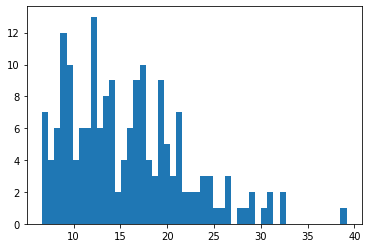

In [22]:
test['const'] = 1
y_pred = ols_boot.predict(new_data=test)
plt.hist(y_pred, bins=50)

### Metrics

In [23]:
print(f"R2: {ols_boot.goodness_of_fit(test)['R2']}")
print(f"MSE: {ols_boot.goodness_of_fit(test)['MSE']}")
print(f"Cor(y, y_pred): {ols_boot.goodness_of_fit(test)['cor']}")

R2: 0.9332124528906267
MSE: 3.155016215315431
Cor(y, y_pred): 0.9680040733122012


### Importância das variáveis

Iremos checar a importância individual de cada variável em relação a variável 'target'. Iremos fazer isto utilizando o método de permutação.

Seja L(y_hat, X, y) a medida de bondade de ajuste do modelo.

1. Calcularemos L_0, que é a medida utilizando os dados de treino inteiros e intocados.
2. Geraremos X* _j que é a permutação da j-ésima coluna de X, sem mexer em outros dados.
3. Computaremos y* _j que é a predição do modelo utilizando X* _j.
4. Calcularemos L* _j(y* _j, X* _j, y)
5. Mediremos a diferença de L_0 - L* _j.

Sendo assim, saberemos o quanto mexer na j-ésima variável influencia na medida de bondade de ajuste do modelo.

Utilizaremos a Root Mean Square Error (RMSE) como nossa medida de ajuste.

In [24]:
model_exp = dx.Explainer(ols_boot,
                         test.drop(columns=['target', 'X5', 'X6', 'X7']),
                         test['target'],
                         label='OLS Bootstrap',
                         model_type='regression',
                         verbose=False)

permutation_explanation = model_exp.model_parts(B = 100, loss_function='rmse')
permutation_explanation.plot()

Temos a conclusão de que X2, X7, X1, X4, X3, X5, X6 são as variáveis mais significantes nessa ordem.

Como nosso modelo é linear e temos uma perfeita correlação entre X2 e X7, diremos que X7 é igualmente importante a X2.

Além disso, nos passos anteriores provamos que X5 e X6 não tem impacto nenhum sobre o nosso modelo. 

A variável const que era apenas um vetor de 1, ela não é possível de permutar já que todos seus valores são iguais. Porém, vemos que a média do modelo não foi rejeitada ao nível de significância de 5%, sendo assim, importante também. Embora, ela não seja uma variável em si.

## XGBoost

Para termos uma comparação com outro modelo e vermos se chegamos a um resultado semelhante. Usaremos o modelo de árvores de decisão, em especial, o ensemble de árvores que é o XGBoost.

In [25]:
xgb_r = XGBRegressor(objective ='reg:squarederror',
                        n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_r.fit(train.drop(columns=['target', 'const']),
          train['target'])
  
# Predict the model
y_pred = xgb_r.predict(test.drop(columns=['target', 'const']).values)

/home/adriel_martins/.cache/pypoetry/virtualenvs/desafio-oncase-Lx6s8YPY-py3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [26]:
print(f"R2: {r2_score(test['target'], y_pred)}")
print(f"MRSE: {mean_squared_error(test['target'], y_pred)}")
print(f"Cor(y, y_pred): {np.corrcoef(test['target'], y_pred)[0,1]}")

R2: 0.9788583094874586
MRSE: 0.9987247514422859
Cor(y, y_pred): 0.9924983115423709


Temos boas medidas de ajuste.

### Importância das Variáveis

Além do método apresentado anteriormente, utilizaremos também os valores SHAP que são bastante populares.

/home/adriel_martins/.cache/pypoetry/virtualenvs/desafio-oncase-Lx6s8YPY-py3.8/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



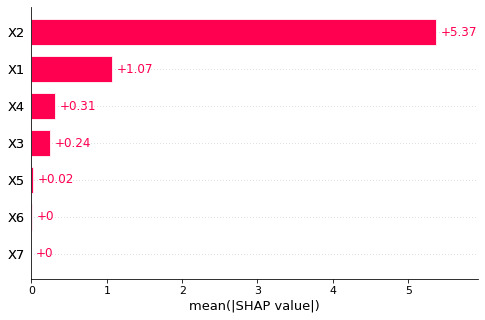

In [27]:
explainer = shap.Explainer(xgb_r)
shap_values = explainer(test.drop(columns=['target', 'const']))

shap.plots.bar(shap_values)

In [28]:
exp = dx.Explainer(xgb_r,
                   train.drop(columns=['target', 'const']),
                   train['target'],
                   verbose=False)

permutation_explanation = exp.model_parts(B = 100, loss_function='rmse')
permutation_explanation.plot()

/home/adriel_martins/.cache/pypoetry/virtualenvs/desafio-oncase-Lx6s8YPY-py3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



Como podemos ver temos duas conclusões interessantes.

O SHAP values chega as mesmas conclusões do método de permutação. E o módelo de árvore chega as mesmas conclusões do nosso modelo linear.

Há algumas coisas a serem notadas no entanto. O X7 é tido como não importante porque o X2 já fez toda a criação de folhas que o X7 poderia fazer. Uma vez que X2 está presente, X7 se torna totalmente inútil para a criação das segmentações das árvore. Isto se dá de maneira análoga com nosso modelo linear.